In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 自定义模型的使用

In [1]:
from fastai.vision import *

In [40]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/home/lyc/.fastai/data/mnist_png/training'),
 PosixPath('/home/lyc/.fastai/data/mnist_png/models'),
 PosixPath('/home/lyc/.fastai/data/mnist_png/testing')]

In [41]:
defaults.cmap='binary'

- 训练集、验证集 tfms
- 这里验证集不做变换

In [42]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [43]:
tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [])

- padding
- random crop

In [6]:
data = (ImageList.from_folder(path, convert_mode='L')
        .split_by_folder(train='training', valid='testing')
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=64)
        .normalize()  # 使用自身的统计信息，因为不是要预训练模型
       )

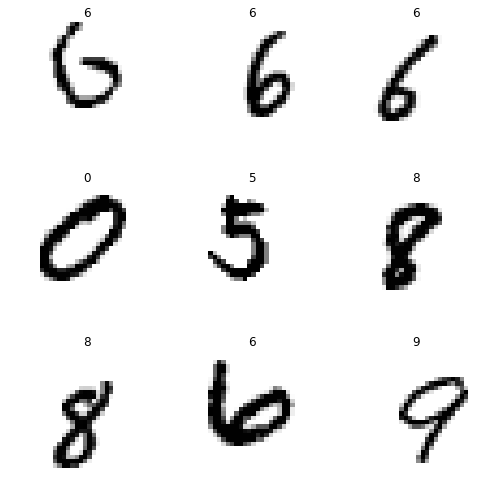

In [7]:
data.show_batch(rows=3, figsize=(7,7))

### 自定义模型

In [8]:
def conv(ni,nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [9]:
doc(Flatten)

class Flatten [source] [test] Flatten ( full : bool = False ) :: Module 
 
 × No tests found for Flatten . To contribute a test please refer to this guide and this discussion . Flatten x to a single dimension, often used at the end of a model. full for rank-1 tensor 
 Show in docs

In [10]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [11]:
doc(Learner)

class Learner [source] [test] Learner ( data : DataBunch , model : Module , opt_func : Callable = 'Adam' , loss_func : Callable = None , metrics : Collection [ Callable ]= None , true_wd : bool = True , bn_wd : bool = True , wd : Floats = 0.01 , train_bn : bool = True , path : str = None , model_dir : PathOrStr = 'models' , callback_fns : Collection [ Callable ]= None , callbacks : Collection [ Callback ]= <factory> , layer_groups : ModuleList = None , add_time : bool = True , silent : bool = None ) 
 
 × No tests found for Learner . To contribute a test please refer to this guide and this discussion . Trainer for model using data to minimize loss_func with optimizer opt_func . 
 Show in docs

In [12]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [13]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [14]:
data.train_ds[0]

(Image (1, 28, 28), Category 7)

7


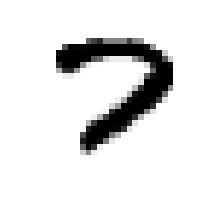

In [15]:
x, y = data.train_ds[0]
x.show()
print(y)

In [16]:
xb, yb = data.one_batch()  # bs=64
xb.shape
yb.shape

torch.Size([64, 1, 28, 28])

torch.Size([64])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02


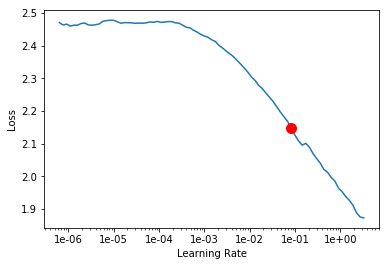

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
lr = 2e-1

In [19]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.286687,0.265215,0.916800,00:08
1,0.256713,0.173404,0.944400,00:08
2,0.178962,0.119607,0.963400,00:08
3,0.125316,0.058706,0.983100,00:08
4,0.076931,0.037404,0.988700,00:08


## 重建模型

In [20]:
def conv2(ni,nf):
    return conv_layer(ni,nf,stride=2)  # 库函数
# conv_layer which lets you create conv, batch norm, ReLU combinations

In [21]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [22]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [23]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-01


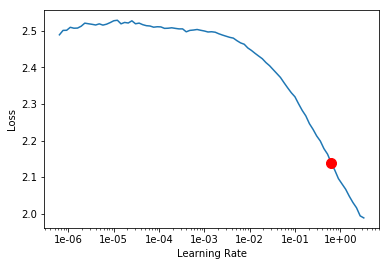

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
lr=1e-1

In [26]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.268805,0.132822,0.956900,00:08
1,0.227748,0.255854,0.915400,00:08
2,0.209142,0.381966,0.880400,00:08
3,0.165852,0.260037,0.921600,00:08
4,0.160655,0.102029,0.968300,00:08
5,0.121476,0.129365,0.959700,00:08
6,0.112839,0.049855,0.984300,00:08
7,0.066354,0.038637,0.987300,00:08
8,0.067430,0.034191,0.989400,00:08
9,0.059260,0.030368,0.990100,00:08


### 残差结构

In [27]:
doc(conv_layer)

conv_layer [source] [test] conv_layer ( ni : int , nf : int , ks : int = 3 , stride : int = 1 , padding : int = None , bias : bool = None , is_1d : bool = False , norm_type : Optional [ NormType ]= <NormType.Batch: 1> , use_activ : bool = True , leaky : float = None , transpose : bool = False , init : Callable = 'kaiming_normal_' , self_attention : bool = False ) 
 
 × No tests found for conv_layer . To contribute a test please refer to this guide and this discussion . Create a sequence of convolutional ( ni to nf ), ReLU (if use_activ ) and batchnorm (if bn ) layers. 
 Show in docs

In [28]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

In [29]:
doc(res_block)

res_block [source] [test] res_block ( nf , dense : bool = False , norm_type : Optional [ NormType ]= <NormType.Batch: 1> , bottle : bool = False , ** conv_kwargs ) 
 
 × No tests found for res_block . To contribute a test please refer to this guide and this discussion . Resnet block of nf features. conv_kwargs are passed to conv_layer . 
 Show in docs

In [30]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [31]:
def conv_and_res(ni,nf):
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [32]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [33]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [34]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

In [35]:
doc(MergeLayer)

class MergeLayer [source] [test] MergeLayer ( dense : bool = False ) :: Module 
 
 × No tests found for MergeLayer . To contribute a test please refer to this guide and this discussion . Merge a shortcut with the result of the module by adding them or concatenating thme if dense=True . 
 Show in docs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-01


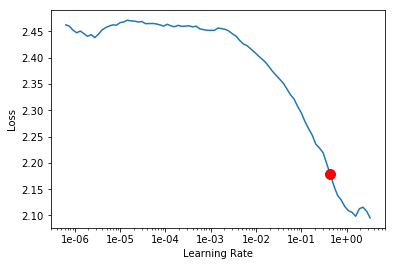

In [36]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [37]:
learn.fit_one_cycle(15, 0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.194276,0.152102,0.957800,00:13
1,0.152755,0.170926,0.942700,00:13
2,0.127692,0.124472,0.963100,00:13
3,0.106741,0.061006,0.980800,00:13
4,0.095490,0.099073,0.973600,00:13
5,0.085740,0.061804,0.980900,00:13
6,0.067191,0.193605,0.940600,00:14
7,0.074187,0.094971,0.969900,00:13
8,0.063273,0.041282,0.987900,00:13
9,0.052292,0.045675,0.986000,00:13


![](../imgs/res.png)

- 使用更简洁的代码构建模型，避免犯错
- 减少重复，重复性工作使用函数完成，使用编程技巧

In [3]:
doc(MergeLayer)

class MergeLayer [source] [test] MergeLayer ( dense : bool = False ) :: Module 
 
 × No tests found for MergeLayer . To contribute a test please refer to this guide and this discussion . Merge a shortcut with the result of the module by adding them or concatenating thme if dense=True . 
 Show in docs

```python
class MergeLayer(nn.Module):
    "Merge a shortcut with the result of the module by adding them or concatenating thme if `dense=True`."
    def __init__(self, dense:bool=False):
        super().__init__()
        self.dense=dense

    def forward(self, x): return torch.cat([x,x.orig], dim=1) if self.dense else (x+x.orig)
```

In [4]:
doc(SequentialEx)

class SequentialEx [source] [test] SequentialEx ( * layers ) :: Module 
 
 × No tests found for SequentialEx . To contribute a test please refer to this guide and this discussion . Like nn.Sequential , but with ModuleList semantics, and can access module input 
 Show in docs

```python
class SequentialEx(nn.Module):
    "Like `nn.Sequential`, but with ModuleList semantics, and can access module input"
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        res = x
        for l in self.layers:
            res.orig = x
            nres = l(res)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            res.orig = None
            res = nres
        return res

    def __getitem__(self,i): return self.layers[i]
    def append(self,l): return self.layers.append(l)
    def extend(self,l): return self.layers.extend(l)
    def insert(self,i,l): return self.layers.insert(i,l)
```

- 使用 SequentialEx 和 MergeLayer可以轻松地创建残差结构

```python
def res_block(nf, dense:bool=False, norm_type:Optional[NormType]=NormType.Batch, bottle:bool=False, **conv_kwargs):
    "Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`."
    norm2 = norm_type
    if not dense and (norm_type==NormType.Batch): norm2 = NormType.BatchZero
    nf_inner = nf//2 if bottle else nf
    return SequentialEx(conv_layer(nf, nf_inner, norm_type=norm_type, **conv_kwargs),
                      conv_layer(nf_inner, nf, norm_type=norm2, **conv_kwargs),
                      MergeLayer(dense))
```

- DensNet在小型数据集上表现往往较好
- 对分割任务也比较友好

### UNET

![](../imgs/unet.png)

in this case, this is from the U-Net paper. Their images, they started with one channel by 572 by 572. This is for medical imaging segmentation. After your stride 2 conv, they're doubling the number of channels to 128, and they're halving the size so they're now down to 280 by 280. In this original unit paper, they didn't add any padding. So they lost a pixel on each side each time they did a conv. That's why you are losing these two. But basically half the size, and then half the size, and then half the size, and then half the size, until they're down to 28 by 28 with 1024 channels.